In [ ]:
import pandas as pd
import zipfile
import numpy as np
from google.colab import drive
import chardet
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade xgboost scikit-learn --no-cache-dir

In [ ]:
zip_path = "/content/default+of+credit+card+clients.zip"

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
file_path = "/content/default of credit card clients.xls"
df = pd.read_excel(file_path, header=1)

In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

Rename the target column for consistency

In [ ]:
df.rename(columns={"default payment next month": "DEFAULT"}, inplace=True)

Drop the ID column if it exists



In [ ]:
df.drop(columns=["ID"], errors='ignore', inplace=True)

Convert all columns to numeric

In [ ]:
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

Dataset is now successfully loaded and pre-processed.

    

*   All columns are numeric
*   No missing values detected



Exploratory Data Analysis (EDA)

1)class distribution

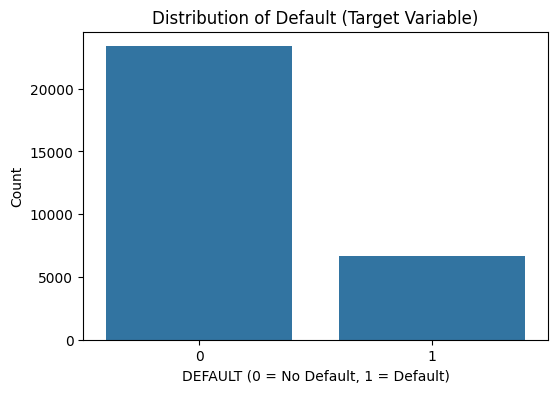

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["DEFAULT"])
plt.title("Distribution of Default (Target Variable)")
plt.xlabel("DEFAULT (0 = No Default, 1 = Default)")
plt.ylabel("Count")
plt.show()


From the above chart:

Class Imbalance:

Majority of the records belong to class 0 (No Default).

Fewer records belong to class 1 (Default).

Need to handle this class imbalance to improve model performance.

Summary Statistics:

In [ ]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


# From the above plot:
1️⃣ Check for Unusual or Incorrect Values
EDUCATION (0 to 6)

Expected values: 1 = Graduate, 2 = University, 3 = High School, 4 = Others
But 0, 5, and 6 appear, which may need to be grouped as "Others."
MARRIAGE (0 to 3)

Expected values: 1 = Married, 2 = Single, 3 = Others
0 is unexpected and might need correction.
PAY_0 to PAY_6 (Repayment Status)

Expected: Values from -2 (no delay) to 8 (worst delay).
The values seem correct.


2️⃣ Check for Outliers
LIMIT_BAL (Credit Limit)

Min = 10,000, Max = 1,000,000
Large range → Need scaling (StandardScaler or MinMaxScaler)
BILL_AMT1 to BILL_AMT6 (Bill Amount)

Some values negative (e.g., -170,000) → Check if errors or refunds.
PAY_AMT1 to PAY_AMT6 (Payment Amount)

Max = 1.6 million, very high values → Likely outliers.



**Data Preprocessing**

Fixing Categorical Values

In [ ]:
df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})
df["MARRIAGE"] = df["MARRIAGE"].replace(0, 3)

Scale Numerical Features

In [ ]:
scale_cols = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3",
              "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2",
              "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

Handle Class Imbalance Using SMOTE

In [ ]:
X = df.drop(columns=["DEFAULT"])
y = df["DEFAULT"]

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
print(y_resampled.value_counts())

DEFAULT
1    23364
0    23364
Name: count, dtype: int64


Now, the distribution is equal distribution for DEFAULT (0 and 1), meaning the dataset is balanced and ready for training.



**Split the Data into Train/Test Sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (37382, 23)
Testing Data Shape: (9346, 23)


**Train and Evaluate Machine Learning Models**

Logistic Regression

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

In [ ]:
lr_grid = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=42),
                       param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

In [ ]:
lr_grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='roc_auc')

In [ ]:
print("🔍 Best Logistic Regression Parameters:", lr_grid.best_params_)
print("📊 Best AUC-ROC Score from GridSearch:", lr_grid.best_score_)

🔍 Best Logistic Regression Parameters: {'C': 0.1, 'solver': 'lbfgs'}
📊 Best AUC-ROC Score from GridSearch: 0.7422785189063072


Train the Optimized Logistic Regression Model

In [ ]:
best_lr_model = LogisticRegression(
    C=0.1,
    solver='lbfgs',
    class_weight="balanced",
    random_state=42
)

In [ ]:
best_lr_model.fit(X_resampled, y_resampled)

LogisticRegression(C=0.1, class_weight='balanced', random_state=42)

In [ ]:
y_pred = best_lr_model.predict(X_test)

In [ ]:
print("Logistic Regression Performance on Real-World Data:")
print(classification_report(y_test, y_pred))

Logistic Regression Performance on Real-World Data:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      4673
           1       0.69      0.67      0.68      4673

    accuracy                           0.69      9346
   macro avg       0.69      0.69      0.69      9346
weighted avg       0.69      0.69      0.69      9346



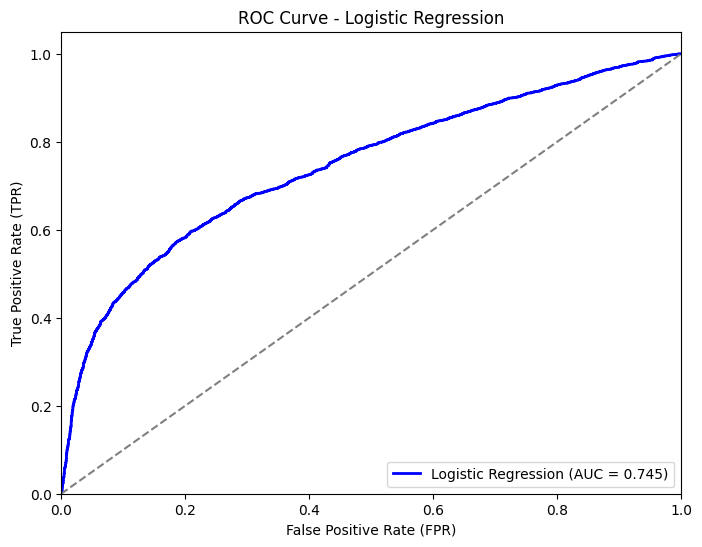

 AUC-ROC Score: 0.7448664828282401


In [ ]:

y_probs = best_lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Logistic Regression (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()
print(" AUC-ROC Score:", roc_auc)

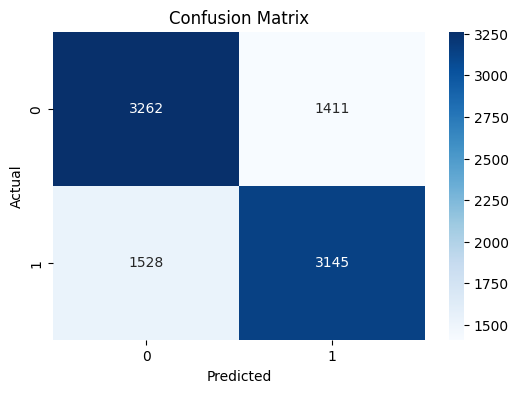

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

AUC-ROC Score = 0.745, which means:

The model is better than random guessing (0.5) but not highly accurate.

Summary:



1.   Precision- The percentage of correct predictions for each class
2.   Recall- The model's ability to detect actual defaults
3.   F1-score- Balance between precision and recall
4.   Accuracy- **69% overall accuracy**

Balanced Precision & Recall: Since recall is high for both classes, the model is not biased towards predicting only non-defaulters.

LightGBM

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [20, 30, 40, 50],
    'min_child_samples': [10, 20, 30, 50]
}

In [ ]:
lgb_grid = RandomizedSearchCV(
    LGBMClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_iter=10,
    n_jobs=-1,
    random_state=42
)

In [ ]:
lgb_grid.fit(X_resampled, y_resampled)


[LightGBM] [Info] Number of positive: 23364, number of negative: 23364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3648
[LightGBM] [Info] Number of data points in the train set: 46728, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_samples': [10, 20, 30, 50],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [20, 30, 40, 50]},
                   random_state=42, scoring='roc_auc')

In [ ]:
print("🔍 Best LightGBM Parameters:", lgb_grid.best_params_)
print("📊 Best AUC-ROC Score from GridSearch:", lgb_grid.best_score_)

🔍 Best LightGBM Parameters: {'num_leaves': 40, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 7, 'learning_rate': 0.2}
📊 Best AUC-ROC Score from GridSearch: 0.9277661506289963


Train LightGBM with Best Hyperparameters

In [ ]:
best_lgb_model = LGBMClassifier(
    num_leaves=40,
    n_estimators=200,
    min_child_samples=20,
    max_depth=7,
    learning_rate=0.2,
    random_state=42
)


In [ ]:
best_lgb_model.fit(X_resampled, y_resampled)

[LightGBM] [Info] Number of positive: 23364, number of negative: 23364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3648
[LightGBM] [Info] Number of data points in the train set: 46728, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=200, num_leaves=40,
               random_state=42)

Evaluate LightGBM on Real Test Data

In [ ]:
y_pred_lgb = best_lgb_model.predict(X_test)
print(" LightGBM Performance on Real-World Data:")
print(classification_report(y_test, y_pred_lgb))

 LightGBM Performance on Real-World Data:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4673
           1       0.97      0.89      0.93      4673

    accuracy                           0.93      9346
   macro avg       0.93      0.93      0.93      9346
weighted avg       0.93      0.93      0.93      9346



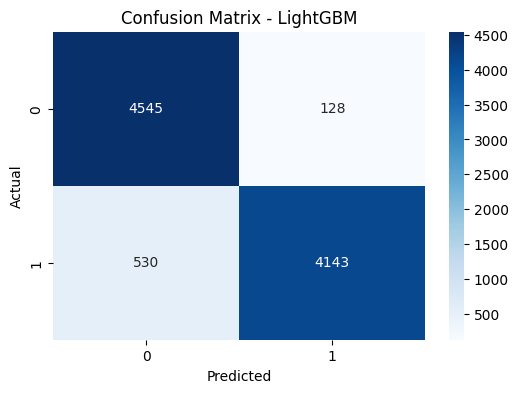

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM")
plt.show()

ROC-AUC Curve for LightGBM

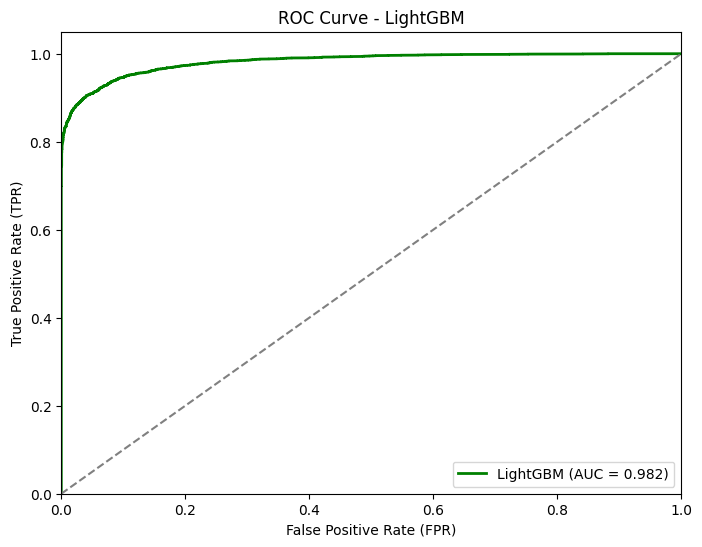

 LightGBM AUC-ROC Score: 0.9818387237509449


In [ ]:
y_probs_lgb = best_lgb_model.predict_proba(X_test)[:,1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_probs_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.figure(figsize=(8,6))
plt.plot(fpr_lgb, tpr_lgb, color='green', lw=2, label='LightGBM (AUC = {:.3f})'.format(roc_auc_lgb))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - LightGBM")
plt.legend(loc="lower right")
plt.show()
print(" LightGBM AUC-ROC Score:", roc_auc_lgb)


Summary:

LightGBM model is performing exceptionally well, with:

AUC-ROC = 0.982  → Almost perfect model discrimination between defaulters and non-defaulters.
Accuracy = 93%  → Very high prediction accuracy.
Precision & Recall = 0.93  → Well-balanced model, making both correct positive and negative predictions.

1️⃣ Highly Effective Model

AUC-ROC of 0.982 suggests a near-perfect model.
Precision & Recall both ~93%, meaning minimal false predictions.

2️⃣ Better Than Logistic Regression

Logistic Regression had an AUC of ~0.74, while LightGBM significantly improved to 0.98.
This shows LightGBM captures non-linear relationships better.

3️⃣ Low False Negatives (High Recall for Class 1)

Recall = 0.89 for Defaulters (1) → The model correctly identifies most risky customers.
This is crucial for credit risk prediction to avoid lending to high-risk clients.

RandomForestClassifier

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_iter=10,
    n_jobs=-1,
    random_state=42
)

In [ ]:
rf_grid.fit(X_resampled, y_resampled)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='roc_auc')

In [ ]:
print("🔍 Best Random Forest Parameters:", rf_grid.best_params_)

🔍 Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}


In [ ]:
best_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42
)

In [ ]:
best_rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [ ]:
y_pred_rf = best_rf_model.predict(X_test)

In [ ]:
print(" Random Forest Performance on Real-World Data:")
print(classification_report(y_test, y_pred_rf))

 Random Forest Performance on Real-World Data:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4673
           1       0.89      0.84      0.87      4673

    accuracy                           0.87      9346
   macro avg       0.87      0.87      0.87      9346
weighted avg       0.87      0.87      0.87      9346



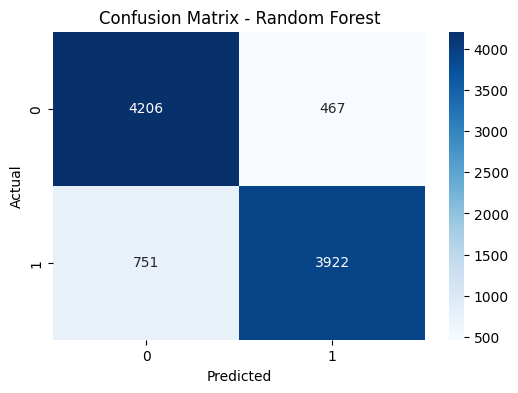

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

ROC-AUC Curve for Random Forest

In [ ]:
y_probs_rf = best_rf_model.predict_proba(X_test)[:,1]

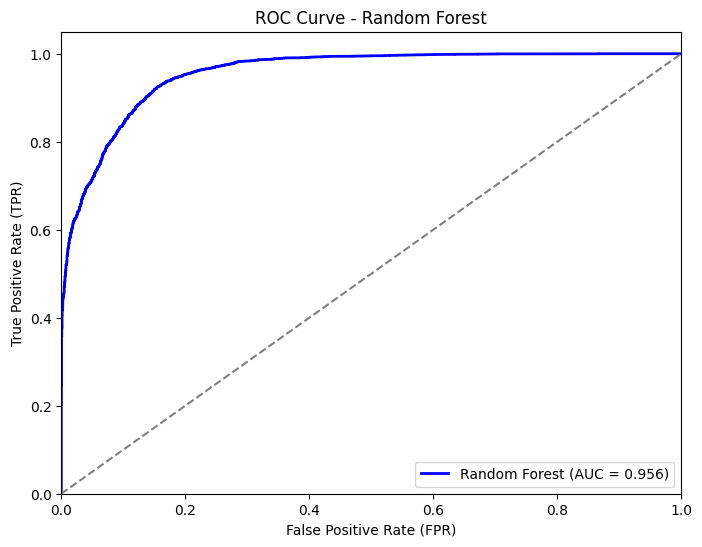

 Random Forest AUC-ROC Score: 0.9555788957320877


In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = {:.3f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()

print(" Random Forest AUC-ROC Score:", roc_auc_rf)


Summary:

Key Observations

✅ High AUC-ROC (0.956) → Strong model for distinguishing between defaulters and non-defaulters.

✅ Balanced Precision & Recall → Good at both identifying and avoiding misclassification of defaulters.

✅ Accuracy = 87% → Reliable, but slightly lower than LightGBM.

⚠ Recall (0.84) is lower than LightGBM (0.89) → Might miss some defaulters.


Performance Comparison Bar Plot

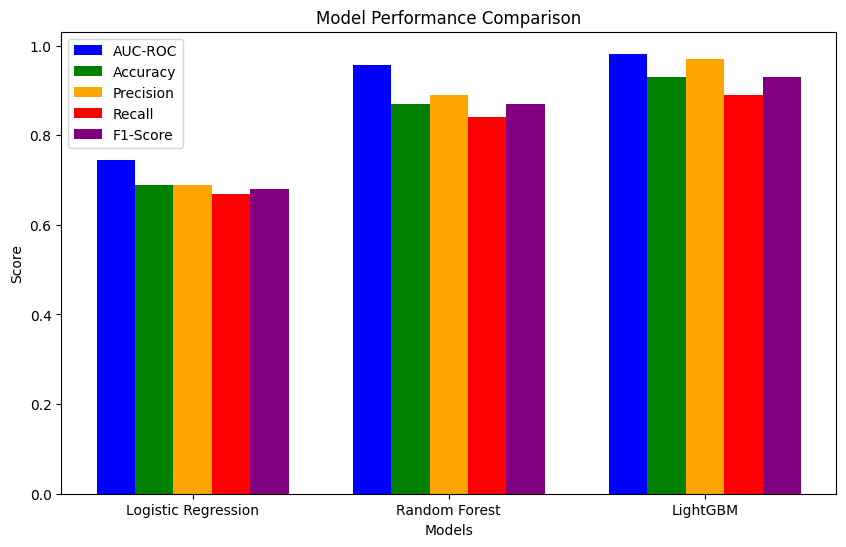

In [ ]:
models = ["Logistic Regression", "Random Forest", "LightGBM"]
auc_roc_scores = [0.745, 0.956, 0.982]
accuracy_scores = [0.69, 0.87, 0.93]
precision_scores = [0.69, 0.89, 0.97]
recall_scores = [0.67, 0.84, 0.89]
f1_scores = [0.68, 0.87, 0.93]
bar_width = 0.15
index = np.arange(len(models))
plt.figure(figsize=(10, 6))
plt.bar(index, auc_roc_scores, bar_width, label="AUC-ROC", color='blue')
plt.bar(index + bar_width, accuracy_scores, bar_width, label="Accuracy", color='green')
plt.bar(index + 2*bar_width, precision_scores, bar_width, label="Precision", color='orange')
plt.bar(index + 3*bar_width, recall_scores, bar_width, label="Recall", color='red')
plt.bar(index + 4*bar_width, f1_scores, bar_width, label="F1-Score", color='purple')

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(index + 2*bar_width, models)
plt.legend()
plt.show()

 The bar chart compares overall performance metrics (AUC-ROC, Accuracy, Precision, Recall, F1-Score).

Key Insights:

1️⃣ LightGBM is the Best Model 🚀

Highest AUC-ROC (0.982) → Best at distinguishing defaulters vs non-defaulters.
Best Accuracy (93%) → Most overall correct predictions.
Best Precision (0.97) → Least false positives.
Best Recall (0.89) → Detects defaulters better than other models.

2️⃣ Random Forest is Strong but Slightly Weaker than LightGBM 🌲

AUC-ROC (0.956) is high, but not as good as LightGBM.
Accuracy (87%) is lower than LightGBM.
Balanced Precision (0.89) & Recall (0.84) but lower than LightGBM.

3️⃣ Logistic Regression is the Weakest ⚠

AUC-ROC (0.745) is significantly lower.
Accuracy (69%) is much lower than both Random Forest & LightGBM.
Precision & Recall are the lowest, making it unsuitable for predicting defaults.

**LightGBM** is the best model for credit risk prediction based on all metrics.

Compare ROC-AUC Curves of All Models

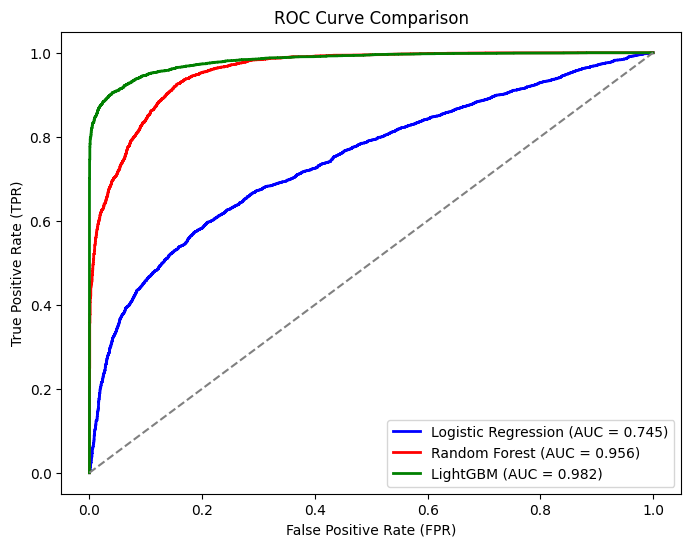

In [ ]:
y_probs_lr = best_lr_model.predict_proba(X_test)[:,1]
y_probs_rf = best_rf_model.predict_proba(X_test)[:,1]
y_probs_lgb = best_lgb_model.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_probs_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (AUC = {:.3f})'.format(roc_auc_lr))
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label='Random Forest (AUC = {:.3f})'.format(roc_auc_rf))
plt.plot(fpr_lgb, tpr_lgb, color='green', lw=2, label='LightGBM (AUC = {:.3f})'.format(roc_auc_lgb))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")

plt.show()


The ROC curve plot shows how well each model separates defaulters vs. non-defaulters.




Deploying the Credit Risk Prediction Model using Streamlit

In [ ]:
import numpy as np
import joblib

In [ ]:
joblib.dump(best_lgb_model, "credit_risk_model.pkl")
print("✅ Model saved successfully as 'credit_risk_model.pkl'!")

✅ Model saved successfully as 'credit_risk_model.pkl'!


In [ ]:
import joblib

# Load the saved model
model = joblib.load("credit_risk_model.pkl")

# Verify model prediction
sample_data = X_test.iloc[0].values.reshape(1, -1)  # Take a single test example
prediction = model.predict(sample_data)
print("✅ Sample Prediction:", "High Risk" if prediction[0] == 1 else "Low Risk")

✅ Sample Prediction: Low Risk


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
import streamlit as st
import joblib
import numpy as np

# Load the trained LightGBM model
model = joblib.load("credit_risk_model.pkl")

# 🎨 App Layout
st.set_page_config(page_title="Credit Risk Prediction", layout="centered")

st.markdown("<h1 style='text-align: center; color: #4CAF50;'>💳 Credit Risk Prediction 🚀</h1>", unsafe_allow_html=True)
st.write("Fill in the details below to check the credit risk status.")

# 📌 User Input Fields
LIMIT_BAL = st.number_input("💰 Credit Limit ($)", min_value=10000, max_value=1000000, step=5000)
AGE = st.number_input("🎂 Age", min_value=18, max_value=80, step=1)
EDUCATION = st.selectbox("🎓 Education Level", ["Graduate School", "University", "High School", "Others"])
MARRIAGE = st.selectbox("💍 Marital Status", ["Married", "Single", "Others"])
PAY_1 = st.slider("📆 Last Month's Repayment Status", -2, 8, 0)
BILL_AMT1 = st.number_input("🧾 Latest Bill Amount ($)", min_value=0, max_value=100000, step=500)
PAY_AMT1 = st.number_input("💳 Last Payment Amount ($)", min_value=0, max_value=100000, step=500)

# 🔄 Convert User Input to Model Format
education_map = {"Graduate School": 1, "University": 2, "High School": 3, "Others": 4}
marriage_map = {"Married": 1, "Single": 2, "Others": 3}

input_data = np.array([
    LIMIT_BAL, AGE, education_map[EDUCATION], marriage_map[MARRIAGE], PAY_1, BILL_AMT1, PAY_AMT1
]).reshape(1, -1)

# 🔮 Prediction Button
if st.button("🔍 Predict Credit Risk"):
    prediction = model.predict(input_data)[0]
    if prediction == 1:
        st.error("⚠️ High Risk: This applicant is likely to default.")
    else:
        st.success("✅ Low Risk: This applicant is unlikely to default.")

st.write("🚀 Built with LightGBM & Streamlit")


2025-01-29 21:00:31.980 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 21:00:31.986 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 21:00:31.999 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 21:00:32.003 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 21:00:32.008 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 21:00:32.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 21:00:32.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-29 21:00:32.031 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar